In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import random
import numpy as np
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

2024-11-11 09:58:22.262817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 09:58:22.946302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:17<00:00, 46.59it/s]


In [4]:
def unet():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
     
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
     
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
     
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
     
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)
    
     
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
     
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)
    
     
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

    return model

1


2024-11-11 09:58:42.557936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-11 09:58:42.589761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-11 09:58:42.589815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-11 09:58:42.592558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-11 09:58:42.592605: I external/local_xla/xla/stream_executor

Epoch 1/300


I0000 00:00:1731329927.492118    5056 service.cc:145] XLA service 0x7f191c002310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731329927.492154    5056 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-11-11 09:58:47.601594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 09:58:49.986356: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1731329957.186509    5056 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.8145 - loss: 0.5549 - recall: 0.1438
Epoch 1: val_recall improved from -inf to 0.00000, saving model to model_1fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 785ms/step - accuracy: 0.8170 - loss: 0.5516 - recall: 0.1418 - val_accuracy: 0.9375 - val_loss: 0.3851 - val_recall: 0.0000e+00
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9961 - loss: 0.1992 - recall: 1.9221e-04
Epoch 2: val_recall did not improve from 0.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9961 - loss: 0.1986 - recall: 1.9052e-04 - val_accuracy: 0.9970 - val_loss: 0.2612 - val_recall: 0.0000e+00
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9990 - loss: 0.1237 - recall: 0.0000e+00
Epoch 3: val_recall did not improve from 0.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9990 - loss: 0.1235 - recall: 0.0000e+00 - val_accuracy: 0.9992 - val_loss: 0.1827 - val_recall: 0.0000e+00
Epoch 4/300
42/42 ━━━━━

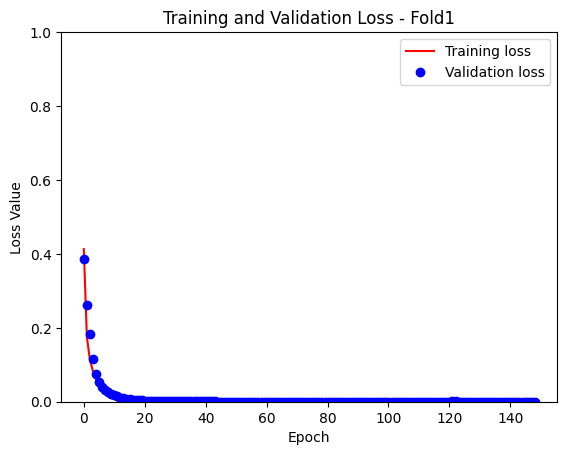

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
Epoch 1/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7763 - loss: 0.6039 - recall: 0.1580
Epoch 1: val_recall improved from -inf to 0.40607, saving model to model_2fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.7793 - loss: 0.6010 - recall: 0.1557 - val_accuracy: 0.7976 - val_loss: 0.8936 - val_recall: 0.4061
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9941 - loss: 0.2771 - recall: 3.8889e-04
Epoch 2: val_recall did not improve from 0.40607
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9941 - loss: 0.2764 - recall: 3.8756e-04 - val_accuracy: 0.9933 - val_loss: 0.3070 - val_recall: 0.0000e+00
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9977 - loss: 0.1667 - recall: 3.7822e-04
Epoch 3: val_recall did not improve from 0.40607
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9978 - loss: 0.1663 - recall: 3.8056e-04 - val_accuracy: 0.9987 - val_loss: 0.2097 - val_recall: 0.0000e+00
Epoch 4/300
4

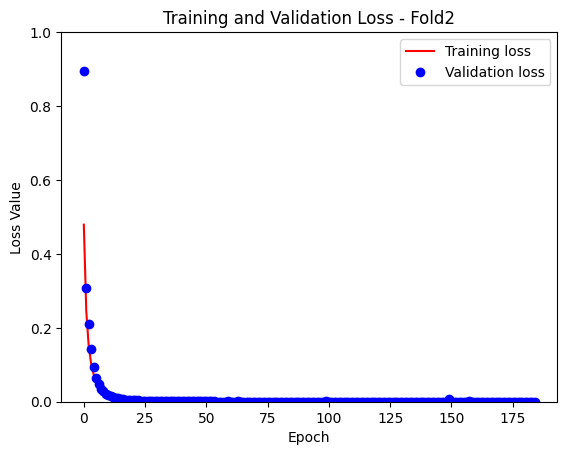

3
Epoch 1/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8899 - loss: 0.4682 - recall: 0.1674
Epoch 1: val_recall improved from -inf to 0.25942, saving model to model_3fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.8912 - loss: 0.4654 - recall: 0.1652 - val_accuracy: 0.9040 - val_loss: 0.4447 - val_recall: 0.2594
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9958 - loss: 0.1565 - recall: 5.6437e-04
Epoch 2: val_recall did not improve from 0.25942
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9958 - loss: 0.1560 - recall: 5.5862e-04 - val_accuracy: 0.9722 - val_loss: 0.2264 - val_recall: 0.2339
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9986 - loss: 0.0919 - recall: 9.6076e-05
Epoch 3: val_recall did not improve from 0.25942
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9986 - loss: 0.0917 - recall: 9.4894e-05 - val_accuracy: 0.9993 - val_loss: 0.1394 - val_recall: 0.0000e+00
Epoch 4/300
42/42

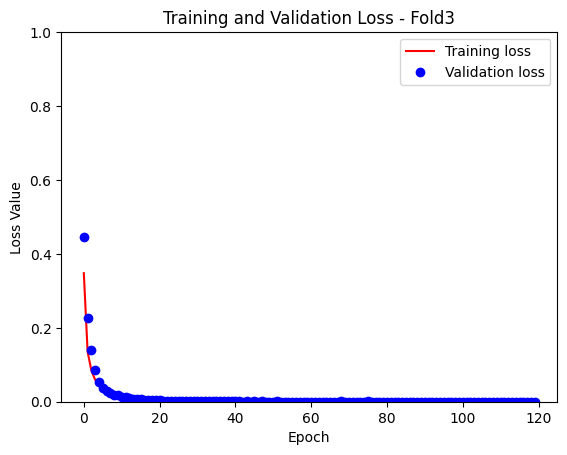

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
Epoch 1/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.6024 - loss: 0.7800 - recall: 0.4459
Epoch 1: val_recall improved from -inf to 0.00008, saving model to model_4fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 786ms/step - accuracy: 0.6073 - loss: 0.7757 - recall: 0.4398 - val_accuracy: 0.9195 - val_loss: 0.5021 - val_recall: 7.8104e-05
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9916 - loss: 0.3160 - recall: 7.9908e-04
Epoch 2: val_recall did not improve from 0.00008
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9916 - loss: 0.3153 - recall: 7.9747e-04 - val_accuracy: 0.9981 - val_loss: 0.3347 - val_recall: 0.0000e+00
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9980 - loss: 0.2172 - recall: 8.3675e-04
Epoch 3: val_recall did not improve from 0.00008
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9980 - loss: 0.2169 - recall: 8.3406e-04 - val_accuracy: 0.9992 - val_loss: 0.2581 - val_recall: 0.0000e+00
Epoch 4/3

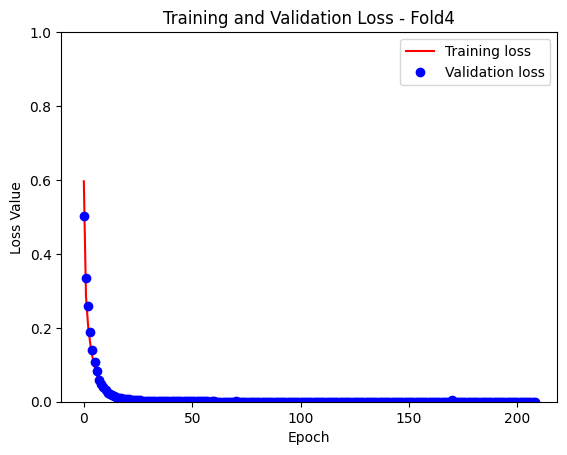

5
Epoch 1/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9091 - loss: 0.4665 - recall: 0.0569
Epoch 1: val_recall improved from -inf to 0.04716, saving model to model_5fold.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - accuracy: 0.9103 - loss: 0.4641 - recall: 0.0563 - val_accuracy: 0.9236 - val_loss: 0.4653 - val_recall: 0.0472
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9975 - loss: 0.2035 - recall: 0.0029
Epoch 2: val_recall did not improve from 0.04716
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9976 - loss: 0.2030 - recall: 0.0029 - val_accuracy: 0.9937 - val_loss: 0.2731 - val_recall: 7.6625e-05
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9990 - loss: 0.1216 - recall: 9.0702e-04
Epoch 3: val_recall did not improve from 0.04716
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9990 - loss: 0.1213 - recall: 9.0485e-04 - val_accuracy: 0.9992 - val_loss: 0.1642 - val_recall: 0.0000e+00
Epoch 4/300
42/42 ━━━

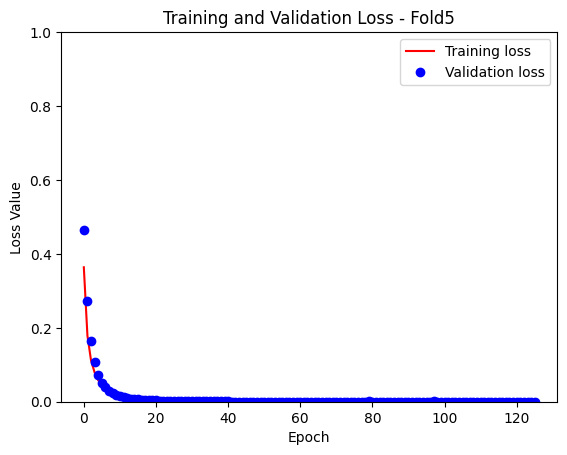

Accuracy: 0.9999450009876333+- 0.00017609466036600823
Jaccard: 0.9102036682735851+- 0.11913617232066497
Dice: 0.9467026635193655+- 0.10361358800034334
Precision: 0.9732370755692372+- 0.0969635130107971
Recall: 0.9270373298152507+- 0.11333088586514627


In [5]:

acc = []
jacc = []
f1 = []
prec = []
rec = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
f = 1

for train_ind, test_ind in kf.split(X):
    print(f)
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = unet()
    
    checkpoint_filepath = 'model_' + str(f)+'fold.keras'
    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_recall',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=300, callbacks=callbacks)
    model.save('model_' + str(f)+'fold.keras')
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    plt.figure()
    plt.plot( loss, 'r', label='Training loss')
    plt.plot( val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss - Fold' + str(f))
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    del model 

    tf.keras.backend.clear_session()

    f+=1
    
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)))
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

In [6]:
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)));
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

Accuracy: 0.9999450009876333+- 0.00017609466036600823
Jaccard: 0.9102036682735851+- 0.11913617232066497
Dice: 0.9467026635193655+- 0.10361358800034334
Precision: 0.9732370755692372+- 0.0969635130107971
Recall: 0.9270373298152507+- 0.11333088586514627


In [7]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


f = 0
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    acc= []
    jacc = []
    f1 = []
    prec = []
    rec = []
    
    model = tf.keras.models.load_model('model_'+str(f+1)+'fold.keras')

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc.append(accuracy_score(sample_mask, predicted_mask))
        jacc.append(jaccard_score(sample_mask, predicted_mask))
        f1.append(f1_score(sample_mask, predicted_mask))
        prec.append(precision_score(sample_mask, predicted_mask))
        rec.append(recall_score(sample_mask, predicted_mask))

    acc_mean_fold.append(np.mean(acc))
    acc_std_fold.append(np.std(acc))
    jacc_mean_fold.append(np.mean(jacc))
    jacc_std_fold.append(np.std(jacc))
    f1_mean_fold.append(np.mean(f1))
    f1_std_fold.append(np.std(f1))
    prec_mean_fold.append(np.mean(prec))
    prec_std_fold.append(np.std(prec))
    rec_mean_fold.append(np.mean(rec))
    rec_std_fold.append(np.std(rec))
    
    print("Model - Fold" + str(f+1)+ "Accuracy: " + str(acc_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Jaccard: " + str(jacc_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Dice: " + str(f1_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Precision: " + str(prec_mean_fold[-1]))
    print("Model - Fold" + str(f+1)+ "Recall: " + str(rec_mean_fold[-1]))

    f += 1

k-fold:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
k-fold:  20%|███████████████▍                                                             | 1/5 [00:30<02:01, 30.26s/it]

Model - Fold1Accuracy: 0.9999332882109142
Model - Fold1Jaccard: 0.9050907227886362
Model - Fold1Dice: 0.943725591759487
Model - Fold1Precision: 0.9756274843516886
Model - Fold1Recall: 0.9157404331708815


k-fold:  40%|██████████████████████████████▊                                              | 2/5 [01:00<01:30, 30.06s/it]

Model - Fold2Accuracy: 0.9999525887625558
Model - Fold2Jaccard: 0.9103169049963284
Model - Fold2Dice: 0.9502145691680607
Model - Fold2Precision: 0.9816279069949354
Model - Fold2Recall: 0.9263967083905139


/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
k-fold:  60%|██████████████████████████████████████████████▏    

Model - Fold3Accuracy: 0.9999118532453265
Model - Fold3Jaccard: 0.8846584327335696
Model - Fold3Dice: 0.9245711598547295
Model - Fold3Precision: 0.9590777448176508
Model - Fold3Recall: 0.9020419585562487


k-fold:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [01:59<00:29, 29.92s/it]

Model - Fold4Accuracy: 0.9999665128970574
Model - Fold4Jaccard: 0.9168764490354879
Model - Fold4Dice: 0.9542765151876594
Model - Fold4Precision: 0.9833320251520058
Model - Fold4Recall: 0.9307432973468011


k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.94s/it]

Model - Fold5Accuracy: 0.999960985012397
Model - Fold5Jaccard: 0.934258735672
Model - Fold5Dice: 0.9608548030027937
Model - Fold5Precision: 0.9665404446169922
Model - Fold5Recall: 0.9604854066377246


In [8]:
print("Accuracy: "+ str(np.mean(acc_mean_fold)*100) + " +- " + str(np.std(acc_std_fold)*100))
print("Jaccard: "+ str(np.mean(jacc_mean_fold)*100) + " +- " + str(np.std(jacc_std_fold)*100))
print("Dice: "+ str(np.mean(f1_mean_fold)*100) + " +- " + str(np.std(f1_std_fold)*100))
print("Precision: "+ str(np.mean(prec_mean_fold)*100) + " +- " + str(np.std(prec_std_fold)*100))
print("Recall: "+ str(np.mean(rec_mean_fold)*100) + " +- " + str(np.std(rec_std_fold)*100))

Accuracy: 99.99450456256503 +- 0.009179618112048081
Jaccard: 91.02402490452043 +- 3.1333591792956748
Dice: 94.67285277945462 +- 3.7634253113415825
Precision: 97.32411211866545 +- 4.340533143817165
Recall: 92.70815608204339 +- 3.370420013318033


In [9]:
best_model = tf.keras.models.load_model('model_5fold.keras')

In [10]:

kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == 4:
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


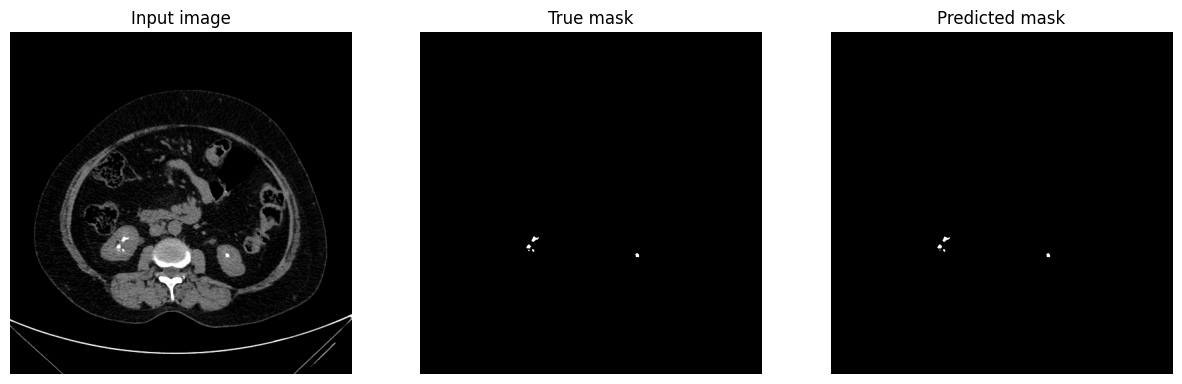

Accuracy: 0.9999847412109375
Jaccard: 0.9661016949152542
Dice: 0.9827586206896551
Precision: 0.991304347826087
Recall: 0.9743589743589743


In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))